In [4]:
from coredotfinance.data import KrxReader
import pandas as pd
krx = KrxReader()
company_df = krx.listed_company()
dataframe = krx.read_date('2022-07-01', kor=True)

In [ ]:
import pandas as pd
import numpy as np
import requests
import lxml
from bs4 import BeautifulSoup
from requests import Response
import re

headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'}

url_upjong = "https://finance.naver.com/sise/sise_group.naver?type=upjong"
res = requests.get(url_upjong, headers=headers)
page_soup = BeautifulSoup(res.text, "lxml")
summary_html = page_soup.select('td a')

upjong_list = pd.DataFrame(re.findall('no=(.+?)">(.+?)</a>',str(summary_html)))
upjong_list = upjong_list.rename(columns={0:"no",1:"upjong"}).sort_values(by=['upjong']).reset_index(drop=True)
upjong_list.no = upjong_list.no.str.zfill(3)

request_upjong_url = "https://finance.naver.com/sise/field_submit.naver?menu=upjong&returnUrl=http%3A%2F%2Ffinance.naver.com%2Fsise%2Fsise_group_detail.naver%3Ftype%3Dupjong%26no%3D"
request_url1 = "&fieldIds=market_sum&fieldIds=property_total&fieldIds=debt_total&fieldIds=sales"
request_url2 = "&fieldIds=operating_profit&fieldIds=net_income&fieldIds=eps&fieldIds=dividend"
#request_url3 = "&fieldIds=per&fieldIds=roe&fieldIds=roa&fieldIds=listed_stock_cnt&fieldIds=pbr&fieldIds=reserve_ratio"

upjong = pd.DataFrame()
for i in (upjong_list['no'].to_list()):
    temp = pd.DataFrame()
    for j in ([request_url1,request_url2]):
        res = requests.get(request_upjong_url+i+j, headers=headers)
        page_soup = BeautifulSoup(res.text, "lxml")
        upjong_data_html = page_soup.select_one('#contentarea > div:nth-child(5)')
        col = [item.get_text().strip() for item in upjong_data_html.select('thead th')]
        col = [x for x in col if x not in ['종목명','토론실']]
        row = [item.get_text().strip() for item in upjong_data_html.select('tbody a')]
        row = list(filter(None,row))
        num = np.array([item.get_text().strip() for item in upjong_data_html.select('td.number')])
        num.resize(len(row),len(col))
        df = pd.DataFrame(num, columns=col,index=row).drop(columns=['현재가','전일비','등락률'])
        df['Sector'] = upjong_list[upjong_list.no==i].upjong.iat[0]
        temp = pd.concat([temp,df], axis = 1)
    #temp.index = pd.MultiIndex.from_product([[upjong_list[upjong_list.no==i].upjong.iat[0]],temp.index],names=["Sector","Stock"])
    upjong = pd.concat([upjong,temp], axis = 0)
    
with pd.ExcelWriter('upjong.xlsx', engine='openpyxl') as writer:
    upjong.to_excel(writer)

In [16]:
listed_company_df = pd.merge(company_df, dataframe, on='종목코드', how='inner')
filtered_companies = listed_company_df[['종목명_x', '시장구분_x', '업종명', '상장주식수_x','업종코드', '시가총액']]

#KOSPI
KOSPI_companies = filtered_companies[filtered_companies['시장구분_x']=="KOSPI"].sort_values(by=['시가총액'])
KOSPI_companies = KOSPI_companies.loc[KOSPI_companies['시가총액'] < 10**12] 

KOSPI_groupby_sum = KOSPI_companies.groupby('업종명')['시가총액'].agg(시가총액='sum', MyCount='count').sort_values(by=['시가총액'])
KOSPI_groupby_mean = KOSPI_companies.groupby('업종명').mean().sort_values(by=['시가총액'])

print(KOSPI_groupby_sum.to_string())

                                              시가총액  MyCount
업종명                                                        
편조원단 제조업                               23520000000        1
전구 및 조명장치 제조업                          31771777950        1
섬유 의복 신발 및 가죽제품 소매업                    43181682090        1
건물설비 설치 공사업                            44055160000        1
자동차 부품 및 내장품 판매업                       44876694040        1
스포츠 서비스업                               47523135900        1
기타 전기장비 제조업                            52740000000        1
그외 기타 제품 제조업                           55732648005        1
그외 기타 운송장비 제조업                         58932367803        1
금속 주조업                                 64565442400        1
도축 육류 가공 및 저장 처리업                      96219510420        1
건축자재 철물 및 난방장치 도매업                    103017291300        1
제재 및 목재 가공업                           103526216465        1
기타 종이 및 판지 제품 제조업                     115565165800        1
보험 및 연금관련 서비스업                        12

In [62]:
#KOSDAQ_companies.to_excel('KOSDAQ_groupby.xlsx')  
#KOSDAQ_companies = filtered_companies[filtered_companies['시장구분_x']=="KOSDAQ"].sort_values(by=['시가총액'])
#KOSDAQ_groupby_sum = KOSDAQ_companies.groupby('업종명').sum().sort_values(by=['시가총액'])
#KOSDAQ_groupby_mean = KOSDAQ_companies.groupby('업종명').mean().sort_values(by=['시가총액'])

상장주식수_x    3.463976e+08
시가총액       2.091478e+12
dtype: float64


                  매출액
Sector               
기타                0.0
생물공학            650.0
통신장비            684.0
판매업체            828.0
컴퓨터와주변기기       1535.0
가정용품           2445.0
레저용장비와제품       2954.0
기타금융           3033.0
창업투자           3127.0
식품과기본식료품소매     3168.0
문구류            3197.0
사무용전자제품        3219.0
운송인프라          3455.0
소프트웨어          3535.0
생명과학도구및서비스     5967.0
건축제품           9861.0
부동산           16632.0
교육서비스         16679.0
디스플레이장비및부품    17843.0
인터넷과카탈로그소매    22099.0
복합유틸리티        25368.0
건강관리장비와용품     34695.0
카드            35881.0
도로와철도운송       45968.0
담배            52284.0
광고            52862.0
가구            56526.0
전문소매          57900.0
핸드셋           58230.0
종이와목재         59775.0
방송과엔터테인먼트     61516.0
호텔레스토랑레저      64950.0
음료            72137.0
게임엔터테인먼트      73261.0
포장재           84237.0
에너지장비및서비스     86265.0
상업서비스와공급품     98045.0
가정용기기와용품     105120.0
양방향미디어와서비스   130734.0
우주항공과국방      132535.0
항공사          148897.0
해운사          199811.0
IT서비스        204604.0
비철금속      

ValueError: x must be 1D

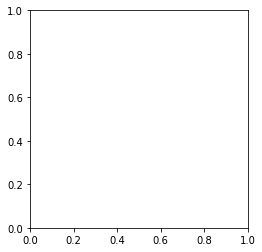

In [57]:
import matplotlib.pyplot as plt
upjong = pd.read_excel('upjong.xlsx', engine='openpyxl')
merged = pd.merge(listed_company_df, upjong, on='종목명_x', how='inner')
merged.dropna()
filtered_companies = merged[['종목명_x', '시장구분_x', '업종명', '영업이익', '시가총액_y', 'Sector','매출액']]

#KOSPI
KOSPI_companies = filtered_companies[filtered_companies['시장구분_x']=="KOSPI"]

KOSPI_companies = KOSPI_companies.apply(lambda x: x.str.replace(',', ''))
KOSPI_companies['영업이익'] = pd.to_numeric(KOSPI_companies['영업이익'])
KOSPI_companies['매출액'] = pd.to_numeric(KOSPI_companies['매출액'])

#KOSPI_companies = KOSPI_companies.loc[KOSPI_companies['시가총액'] < 10**12] 
KOSPI_groupby_sum = KOSPI_companies.groupby('Sector')['매출액'].agg(매출액='sum').sort_values(by=['매출액'])
#KOSPI_groupby_sum = KOSPI_companies.groupby('Sector')['시가총액'].agg(시가총액='sum', MyCount='count').sort_values(by=['시가총액'])
#KOSPI_groupby_mean = KOSPI_companies.groupby('Sector').mean().sort_values(by=['시가총액'])


print(KOSPI_groupby_sum.to_string())
plt.pie(KOSPI_groupby_sum)
